In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
from pathlib import Path

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../src')
from settings import REPLAY_DIR, YOUTUBE_DIR, TIMESTAMPS_DIR
from youtube import convert_to_timestamp
from dota import Match
from attacks import find_hp_decreasing_intervals, find_low_hp_intervals, find_low_and_decreasing_hp_intervals

pd.options.display.max_columns = 60

2022-09-07 20:34:40.831 | INFO     | settings:<module>:10 - .env file exists: True
2022-09-07 20:34:40.832 | INFO     | settings:<module>:13 - ROOT_DIR='/home/gosu/dota-highlights'
2022-09-07 20:34:40.832 | INFO     | settings:<module>:19 - REPLAY_DIR='/home/gosu/dota-highlights/replays'
2022-09-07 20:34:40.833 | INFO     | settings:<module>:22 - REDIS_URL='redis://localhost'


In [2]:
match = Match(6676393091, Path(REPLAY_DIR) / '6676393091.jsonlines')
match.parse()
match

Match: 6676393091, parsed: True

In [3]:
player = match.players[1]
player

MatchPlayer at match: 6676393091, slot: 1, hero_name: npc_dota_hero_pangolier, steam_id: 76561198134243802

In [4]:
player.hp

-89       580
-88       580
-87       580
-86       580
-85       580
         ... 
 2076    2413
 2077    2430
 2078    2515
 2079    2512
 2080    2490
Name: hp, Length: 2170, dtype: int64

In [5]:
player.hp.t(15 * 60, 16 * 60)

900    1250
901    1250
902    1238
903    1239
904    1278
       ... 
956    1290
957    1290
958    1290
959    1258
960    1138
Name: hp, Length: 61, dtype: int64

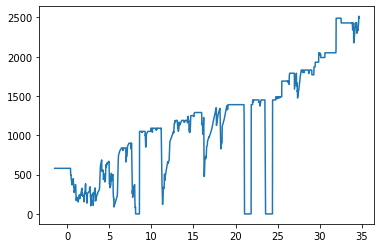

In [6]:
plt.plot(player.hp.index / 60, player.hp)

## Deaths

In [7]:
player.deaths

time                  type  value                 attackername  \
0   487  DOTA_COMBATLOG_DEATH    131   npc_dota_hero_ember_spirit   
1  1263  DOTA_COMBATLOG_DEATH     22  npc_dota_hero_skywrath_mage   
2  1412  DOTA_COMBATLOG_DEATH    237           npc_dota_hero_luna   

                targetname                   sourcename  \
0  npc_dota_hero_pangolier   npc_dota_hero_ember_spirit   
1  npc_dota_hero_pangolier  npc_dota_hero_skywrath_mage   
2  npc_dota_hero_pangolier           npc_dota_hero_luna   

          targetsourcename  attackerhero  targethero  attackerillusion  \
0  npc_dota_hero_pangolier          True        True             False   
1  npc_dota_hero_pangolier          True        True             False   
2  npc_dota_hero_pangolier          True        True             False   

   targetillusion                   inflictor  
0           False                dota_unknown  
1           False  skywrath_mage_mystic_flare  
2           False            luna_lucent_beam

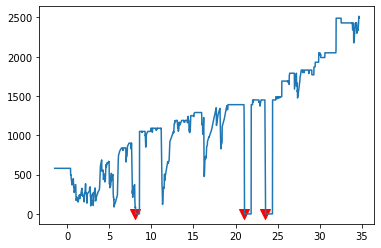

In [8]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
plt.show()

## YouTube

In [9]:
df_youtube = pd.read_csv(YOUTUBE_DIR / 'XTngObUROMo.csv')
df_youtube

video_id  cluster  start    end  start_time  end_time
0   XTngObUROMo        0  00:19  00:02          19         2
1   XTngObUROMo        1  01:00  01:19          60        79
2   XTngObUROMo        2  02:38  03:14         158       194
3   XTngObUROMo        3  04:30  05:35         270       335
4   XTngObUROMo        4  14:19  14:56         859       896
5   XTngObUROMo        5  15:53  16:13         953       973
6   XTngObUROMo        6  18:06  18:13        1086      1093
7   XTngObUROMo        7  18:47  18:56        1127      1136
8   XTngObUROMo        8  21:11  21:47        1271      1307
9   XTngObUROMo        9  22:34  24:25        1354      1465
10  XTngObUROMo       10  25:52  26:36        1552      1596
11  XTngObUROMo       11  27:26  27:59        1646      1679
12  XTngObUROMo       12  28:12  30:24        1692      1824

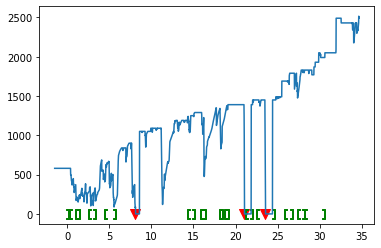

In [10]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='g', marker='$]$', s=100)
plt.show()

## Remove trend

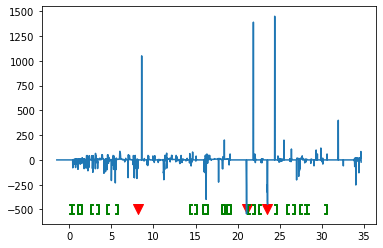

In [11]:
fig, ax = plt.subplots()
# ax.plot(player.hp.index / 60, player.hp)
ax.plot(player.dhp.index / 60, player.dhp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], -500), color='r', marker='v', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], -500), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], -500), color='g', marker='$]$', s=100)
plt.show()

## Zoom

In [12]:
# 11:09 - 11:30

In [13]:
zoom_start = 10.5 * 60
zoom_end = 12 * 60
df_youtube_slice = df_youtube[(df_youtube['start_time'] >= zoom_start) & (df_youtube['end_time'] <= zoom_end)]

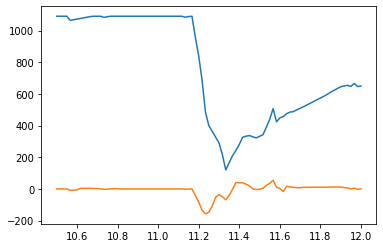

In [14]:
fig, ax = plt.subplots()
ax.plot(player.hp.t(zoom_start, zoom_end).index / 60, player.hp.t(zoom_start, zoom_end))
ax.plot(player.sdhp.t(zoom_start, zoom_end).index / 60, player.sdhp.t(zoom_start, zoom_end))
ax.scatter(
    x=player.deaths.t(zoom_start, zoom_end)['time'] / 60, 
    y=np.full(player.deaths.t(zoom_start, zoom_end).shape[0], -500),
    color='r', marker='v', s=100)
ax.scatter(x=df_youtube_slice['start_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube_slice['end_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$]$', s=100)
plt.show()

Начало

- Отрицательная скорость (Может медленно убывать)
- Абсолютное значение хп < 30%

Конец
- Конец падения хп

In [15]:
from utils import TimeSeries

In [16]:
player.hp / player.max_hp

-89      1.000000
-88      1.000000
-87      1.000000
-86      1.000000
-85      1.000000
           ...   
 2076    0.993004
 2077    1.000000
 2078    1.000000
 2079    0.998807
 2080    0.990060
Name: hp, Length: 2170, dtype: float64

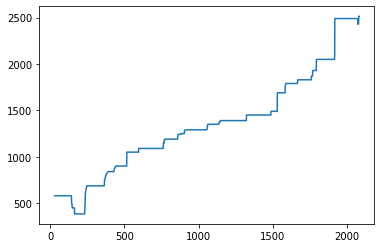

In [17]:
plt.plot(player.hp.rolling(120).max())

In [18]:
signal_sdhp = player.sdhp < -20
signal_sdhp = TimeSeries(signal_sdhp)

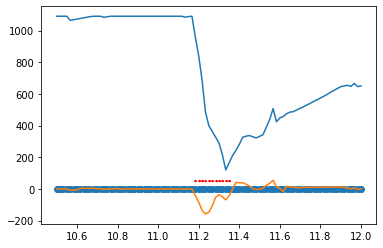

In [19]:
fig, ax = plt.subplots()
ax.plot(player.hp.t(zoom_start, zoom_end).index / 60, player.hp.t(zoom_start, zoom_end))
ax.plot(player.sdhp.t(zoom_start, zoom_end).index / 60, player.sdhp.t(zoom_start, zoom_end))
ax.scatter(
    x=player.deaths.t(zoom_start, zoom_end)['time'] / 60, 
    y=np.full(player.deaths.t(zoom_start, zoom_end).shape[0], -500),
    color='r', marker='v', s=100)
ax.scatter(x=df_youtube_slice['start_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$[$', s=100)
ax.scatter(x=df_youtube_slice['end_time'] / 60, y=np.full(df_youtube_slice.shape[0], -500), color='g', marker='$]$', s=100)
ax.scatter(x=signal_sdhp.t(zoom_start, zoom_end).index / 60, y=signal_sdhp.t(zoom_start, zoom_end) * 50, color='r', marker='$*$', s=5)
ax.scatter(x=signal_sdhp.t(zoom_start, zoom_end).index / 60, y=signal_sdhp.t(zoom_start, zoom_end))
plt.show()

# Detector

In [20]:
df_attacks = player.as_attacker
df_attacks

start   end  target_dead  \
0     305   321         True   
5     380   390         True   
4     418   424         True   
2     552   559         True   
6     582   592         True   
3     582   588         True   
1     662   690         True   
4     676   693         True   
2     825   836         True   
7     951   955        False   
8     973   980         True   
9    1064  1068         True   
4    1636  1649         True   
7    1781  1792         True   
4    2010  2037        False   
8    2025  2031         True   
9    2047  2055        False   
10   2067  2080         True   

                                      attacker_heroes  \
0   [MatchPlayer at match: 6676393091, slot: 3, he...   
5   [MatchPlayer at match: 6676393091, slot: 3, he...   
4   [MatchPlayer at match: 6676393091, slot: 1, he...   
2   [MatchPlayer at match: 6676393091, slot: 2, he...   
6   [MatchPlayer at match: 6676393091, slot: 2, he...   
3   [MatchPlayer at match: 6676393091, slot: 1, he...   
1   [MatchPlayer at match: 6676393091, slot: 1, he...   
4   [MatchPlayer at match: 6676393091, slot: 1, he...   
2   [MatchPlayer at match: 6676393091, slot: 3, he...   
7   [MatchPlayer at match: 6676393091, slot: 1, he...   
8   [MatchPlayer at match: 6676393091, slot: 1, he...   
9   [MatchPlayer at match: 6676393091, slot: 1, he...   
4   [MatchPlayer at match: 6676393091, slot: 1, he...   
7   [MatchPlayer at match: 6676393091, slot: 3, he...   
4   [MatchPlayer at match: 6676393091, slot: 1, he...   
8   [MatchPlayer at match: 6676393091, slot: 1, he...   
9   [MatchPlayer at match: 6676393091, slot: 5, he...   
10  [MatchPlayer at match: 6676393091, slot: 1, he...   

                                               target  
0   MatchPlayer at match: 6676393091, slot: 7, her...  
5   MatchPlayer at match: 6676393091, slot: 6, her...  
4   MatchPlayer at match: 6676393091, slot: 5, her...  
2   MatchPlayer at match: 6676393091, slot: 7, her...  
6   MatchPlayer at match: 6676393091, slot: 5, her...  
3   MatchPlayer at match: 6676393091, slot: 8, her...  
1   MatchPlayer at match: 6676393091, slot: 9, her...  
4   MatchPlayer at match: 6676393091, slot: 8, her...  
2   MatchPlayer at match: 6676393091, slot: 9, her...  
7   MatchPlayer at match: 6676393091, slot: 5, her...  
8   MatchPlayer at match: 6676393091, slot: 5, her...  
9   MatchPlayer at match: 6676393091, slot: 5, her...  
4   MatchPlayer at match: 6676393091, slot: 7, her...  
7   MatchPlayer at match: 6676393091, slot: 8, her...  
4   MatchPlayer at match: 6676393091, slot: 9, her...  
8   MatchPlayer at match: 6676393091, slot: 8, her...  
9   MatchPlayer at match: 6676393091, slot: 8, her...  
10  MatchPlayer at match: 6676393091, slot: 8, her...

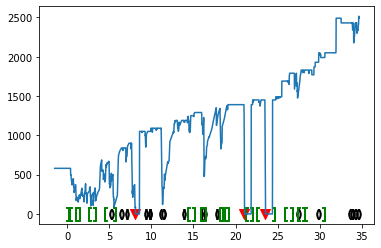

In [21]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
ax.scatter(x=df_attacks['start'] / 60, y=np.full(df_attacks.shape[0], 0), color='black', marker='$($', s=100)
ax.scatter(x=df_attacks['end'] / 60, y=np.full(df_attacks.shape[0], 0), color='black', marker='$)$', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='green', marker='$[$', s=200)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='green', marker='$]$', s=200)
plt.show()

In [22]:
player.as_attacker.target_dead.sum()

15

In [23]:
[p.as_target.target_dead.sum() for p in match.players]

[3, 3, 1, 4, 7, 7, 4, 4, 9, 3]

- Merge as_target (alive) and as_attacker (killed)
- Calculate IoU with YouTube

In [24]:
# player.action_moments

In [25]:
# df_youtube

In [26]:
# match.action_moments

In [27]:
match.action_moments

start   end  time
0      -8    -1    -8
1      53    78    53
2     100   107   100
3     133   143   133
4     163   191   163
5     210   228   210
6     243   268   243
7     279   291   279
8     305   337   305
9     380   401   380
10    418   424   418
11    456   503   456
12    517   527   517
13    552   559   552
14    582   592   582
15    649   698   649
16    825   836   825
17    921   927   921
18    951   980   951
19    990  1005   990
20   1064  1068  1064
21   1261  1272  1261
22   1410  1447  1410
23   1504  1509  1504
24   1629  1649  1629
25   1689  1693  1689
26   1768  1792  1768
27   2010  2037  2010
28   2047  2055  2047
29   2067  2080  2067

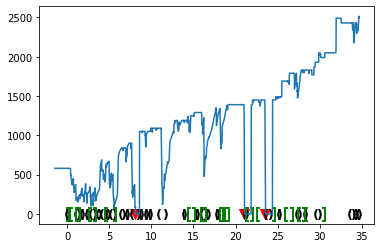

In [28]:
fig, ax = plt.subplots()
ax.plot(player.hp.index / 60, player.hp)
ax.scatter(x=player.deaths['time'] / 60, y=np.full(player.deaths.shape[0], 0), color='r', marker='v', s=100)
ax.scatter(x=match.action_moments['start'] / 60, y=np.full(match.action_moments.shape[0], 0), color='black', marker='$($', s=100)
ax.scatter(x=match.action_moments['end'] / 60, y=np.full(match.action_moments.shape[0], 0), color='black', marker='$)$', s=100)
ax.scatter(x=df_youtube['start_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='green', marker='$[$', s=200)
ax.scatter(x=df_youtube['end_time'] / 60, y=np.full(df_youtube.shape[0], 0), color='green', marker='$]$', s=200)
plt.show()

In [35]:
from utils import convert_to_dota_clock_format

match_moments = match.action_moments[['start', 'end']].to_dict('records')

In [30]:
youtube_moments = (
    df_youtube[['start_time', 'end_time']]
    .rename(columns=dict(start_time='start', end_time='end'))
    .to_dict('records')
)
youtube_moments

[{'start': 19, 'end': 2},
 {'start': 60, 'end': 79},
 {'start': 158, 'end': 194},
 {'start': 270, 'end': 335},
 {'start': 859, 'end': 896},
 {'start': 953, 'end': 973},
 {'start': 1086, 'end': 1093},
 {'start': 1127, 'end': 1136},
 {'start': 1271, 'end': 1307},
 {'start': 1354, 'end': 1465},
 {'start': 1552, 'end': 1596},
 {'start': 1646, 'end': 1679},
 {'start': 1692, 'end': 1824}]

In [31]:
from utils import merge_close_intervals

merge_close_intervals(youtube_moments + match_moments, gap=0)

[{'start': -8, 'end': -1},
 {'start': 19, 'end': 2},
 {'start': 53, 'end': 79},
 {'start': 100, 'end': 107},
 {'start': 133, 'end': 143},
 {'start': 158, 'end': 194},
 {'start': 210, 'end': 228},
 {'start': 243, 'end': 268},
 {'start': 270, 'end': 337},
 {'start': 380, 'end': 401},
 {'start': 418, 'end': 424},
 {'start': 456, 'end': 503},
 {'start': 517, 'end': 527},
 {'start': 552, 'end': 559},
 {'start': 582, 'end': 592},
 {'start': 649, 'end': 698},
 {'start': 825, 'end': 836},
 {'start': 859, 'end': 896},
 {'start': 921, 'end': 927},
 {'start': 951, 'end': 980},
 {'start': 990, 'end': 1005},
 {'start': 1064, 'end': 1068},
 {'start': 1086, 'end': 1093},
 {'start': 1127, 'end': 1136},
 {'start': 1261, 'end': 1307},
 {'start': 1354, 'end': 1465},
 {'start': 1504, 'end': 1509},
 {'start': 1552, 'end': 1596},
 {'start': 1629, 'end': 1679},
 {'start': 1689, 'end': 1824},
 {'start': 2010, 'end': 2037},
 {'start': 2047, 'end': 2055},
 {'start': 2067, 'end': 2080}]

In [32]:
from utils import get_intersections, get_intersection

get_intersections(youtube_moments, match_moments)

[{'start': 60, 'end': 78},
 {'start': 163, 'end': 191},
 {'start': 279, 'end': 291},
 {'start': 305, 'end': 335},
 {'start': 953, 'end': 973},
 {'start': 1271, 'end': 1272},
 {'start': 1410, 'end': 1447},
 {'start': 1646, 'end': 1649},
 {'start': 1692, 'end': 1693},
 {'start': 1768, 'end': 1792}]

In [33]:
from utils import calculate_iou

calculate_iou(match_moments, youtube_moments)

0.1963882618510158

In [38]:
calculate_iou([r for r in match_moments if r['start'] > 10 * 60], youtube_moments)

0.12129760225669958

In [36]:
[
    dict(
        start=convert_to_dota_clock_format(record['start']),
        end=convert_to_dota_clock_format(record['end']),
) for record in youtube_moments]

[{'start': '00:19', 'end': '00:02'},
 {'start': '01:00', 'end': '01:19'},
 {'start': '02:38', 'end': '03:14'},
 {'start': '04:30', 'end': '05:35'},
 {'start': '14:19', 'end': '14:56'},
 {'start': '15:53', 'end': '16:13'},
 {'start': '18:06', 'end': '18:13'},
 {'start': '18:47', 'end': '18:56'},
 {'start': '21:11', 'end': '21:47'},
 {'start': '22:34', 'end': '24:25'},
 {'start': '25:52', 'end': '26:36'},
 {'start': '27:26', 'end': '27:59'},
 {'start': '28:12', 'end': '30:24'}]

In [34]:
[
    dict(
        start=convert_to_dota_clock_format(record['start']),
        end=convert_to_dota_clock_format(record['end']),
) for record in match_moments]

[{'start': '-1:52', 'end': '-1:59'},
 {'start': '00:53', 'end': '01:18'},
 {'start': '01:40', 'end': '01:47'},
 {'start': '02:13', 'end': '02:23'},
 {'start': '02:43', 'end': '03:11'},
 {'start': '03:30', 'end': '03:48'},
 {'start': '04:03', 'end': '04:28'},
 {'start': '04:39', 'end': '04:51'},
 {'start': '05:05', 'end': '05:37'},
 {'start': '06:20', 'end': '06:41'},
 {'start': '06:58', 'end': '07:04'},
 {'start': '07:36', 'end': '08:23'},
 {'start': '08:37', 'end': '08:47'},
 {'start': '09:12', 'end': '09:19'},
 {'start': '09:42', 'end': '09:52'},
 {'start': '10:49', 'end': '11:38'},
 {'start': '13:45', 'end': '13:56'},
 {'start': '15:21', 'end': '15:27'},
 {'start': '15:51', 'end': '16:20'},
 {'start': '16:30', 'end': '16:45'},
 {'start': '17:44', 'end': '17:48'},
 {'start': '21:01', 'end': '21:12'},
 {'start': '23:30', 'end': '24:07'},
 {'start': '25:04', 'end': '25:09'},
 {'start': '27:09', 'end': '27:29'},
 {'start': '28:09', 'end': '28:13'},
 {'start': '29:28', 'end': '29:52'},
 

- Вычесть SMOOTH_WINDOW из начал и концов
- На лайнинге зачастую моменты скучные
- Не хватает информации, где экшен. Куда смотреть?
- Не понятно, насколько эпичный момент
- После лайнинга все гораздо веселее
- Фраги 1х1
- Масс-файты
- Киллы по матчу распределены в разных участках карты. Причем могут смешиваться в один длинный интересные и скучные моменты {'start': '10:49', 'end': '11:38'},
- Одна драка разбилась на 3 хайлайта {'start': '33:30', 'end': '33:57'}, {'start': '34:07', 'end': '34:15'}, {'start': '34:27', 'end': '34:40'}]

Плюс-минус интересное
- {'start': '10:49', 'end': '11:38'} в конце
- {'start': '21:01', 'end': '21:12'},

YouTube моменты из других матчей в серии, например
- {'start': 1692, 'end': 1824}